In [1]:
import maboss
from tqdm import tqdm
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

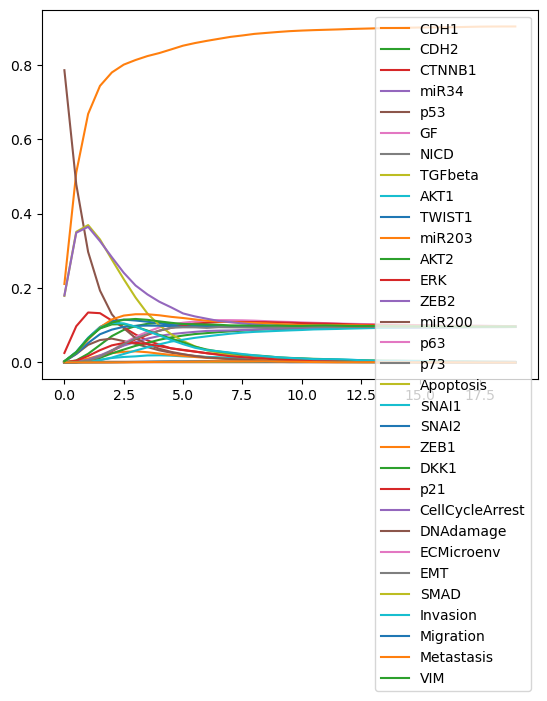

In [2]:
model = maboss.loadBNet('/home/spankaew/Git/BooleanBenchmark/models/Invasion/Invasion_Master_Model.bnet')
model.update_parameters(max_time = 20)
model.network.set_istate('miR200',[0,1])

simulation = model.run()
simulation.plot_node_trajectory()
model_nodes = model.network.names

In [4]:
# Create blank file to get the results
ensemble_results = {}

path = '/home/spankaew/Git/BooleanBenchmark/models/Invasion/' 
model_list = os.listdir(path)

mir_list = ['miR200','miR203','miR34']
model_nodes = model.network.names

for model in tqdm(model_list):

    # Load model
    simulations = maboss.loadBNet(path + model)

    # Setup the model initial condition
    ## Put all inputs at 0
    for i in model_nodes:
        simulations.network.set_istate(i,[1,0])
    ## Put all miR at 1
    for i in mir_list:
        simulations.network.set_istate(i,[0,1])

    # Modify the parameter of the model
    simulations.update_parameters(sample_count = 10000,
                                  thread_count = 15,
                                  max_time = 20,
                                  time_tick = 1)
    simulations.network.set_output(simulations.network.names)

    # Perform simulations
    result = simulations.run()

    # Get matrix
    model_mtx = result.get_nodes_probtraj().copy()

    # Setup cell matrix
    ## Cells
    model_mtx['model_id'] = model.replace('.bnet','')
    ## Timepoint
    model_mtx['timepoint'] = model_mtx.index
    ## Change index
    model_mtx.index = model_mtx.index.map(str)
    model_mtx.index = model + '_' + model_mtx.index

    # Concatenate model results in dictionary
    ensemble_results[model] = model_mtx

# Save the simulation to /tmp folder
simulation_df = pd.concat(ensemble_results.values(), ignore_index = True)
simulation_df.to_csv('/home/spankaew/Git/BooleanBenchmark/tmp/Invasion_simulation_miR.csv')

100%|██████████| 1025/1025 [12:43<00:00,  1.34it/s]


In [2]:
cl_df = pd.read_csv('/home/spankaew/Git/BooleanBenchmark/tmp/Invasion_simulation_miR.csv', index_col = 0)
cl_df.index = cl_df.model_id + '_' + [str(f) for f in cl_df.timepoint]
cl_df.index.name = None

In [33]:
# Initialize PCA (let's reduce to 2 principal components for this example)
pca = PCA(n_components=10)

# Fit and transform the data
df_pca = cl_df.drop(['model_id','timepoint'], axis = 1) 
pca_result = pca.fit_transform(df_pca)

# Convert the result back to a DataFrame for easier interpretation
pca_df = pd.DataFrame(data=pca_result, index=df_pca.index)

# number pca column
number_list = list(range(pca_result.shape[1]))
str_list = [str(i+1) for i in number_list]
pca_df.columns = ['pc' + s for s in str_list]

# Add model_id and timepoint backinto dataframe
pca_df['model_id'] = cl_df['model_id']
pca_df['timepoint'] = cl_df['timepoint'].astype('float')

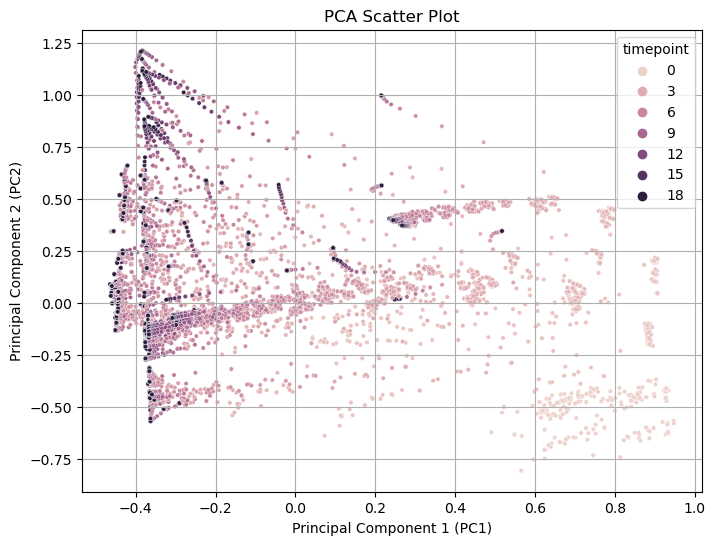

In [34]:
plt.figure(figsize=(8, 6))

# Scatter plot using Seaborn
sns.scatterplot(data = pca_df, x='pc1', y='pc2', s=10, hue = pca_df['timepoint'])

# Add title and labels
plt.title('PCA Scatter Plot')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')

# Display the plot
plt.grid(True)
plt.show()

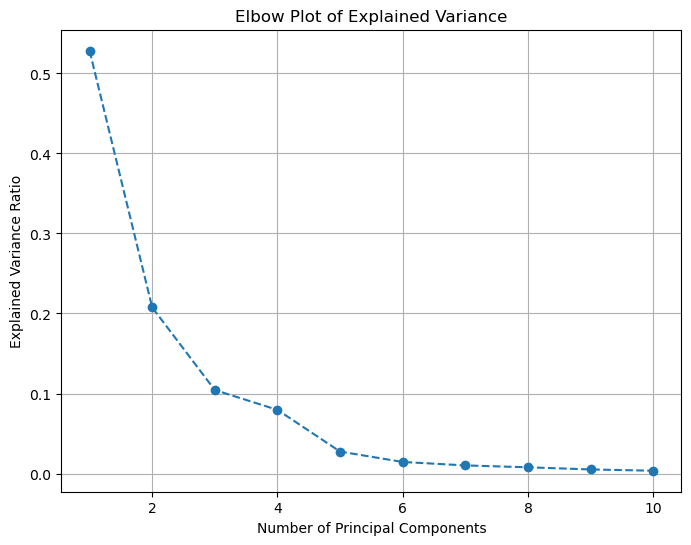

In [35]:
explained_variance_ratio = pca.explained_variance_ratio_

# Create an array with the number of components (1, 2, ..., n)
components = np.arange(1, len(explained_variance_ratio) + 1)

# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(components, explained_variance_ratio, marker='o', linestyle='--')

# Add titles and labels
plt.title('Elbow Plot of Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')

# Add a grid
plt.grid(True)

# Display the plot
plt.show()

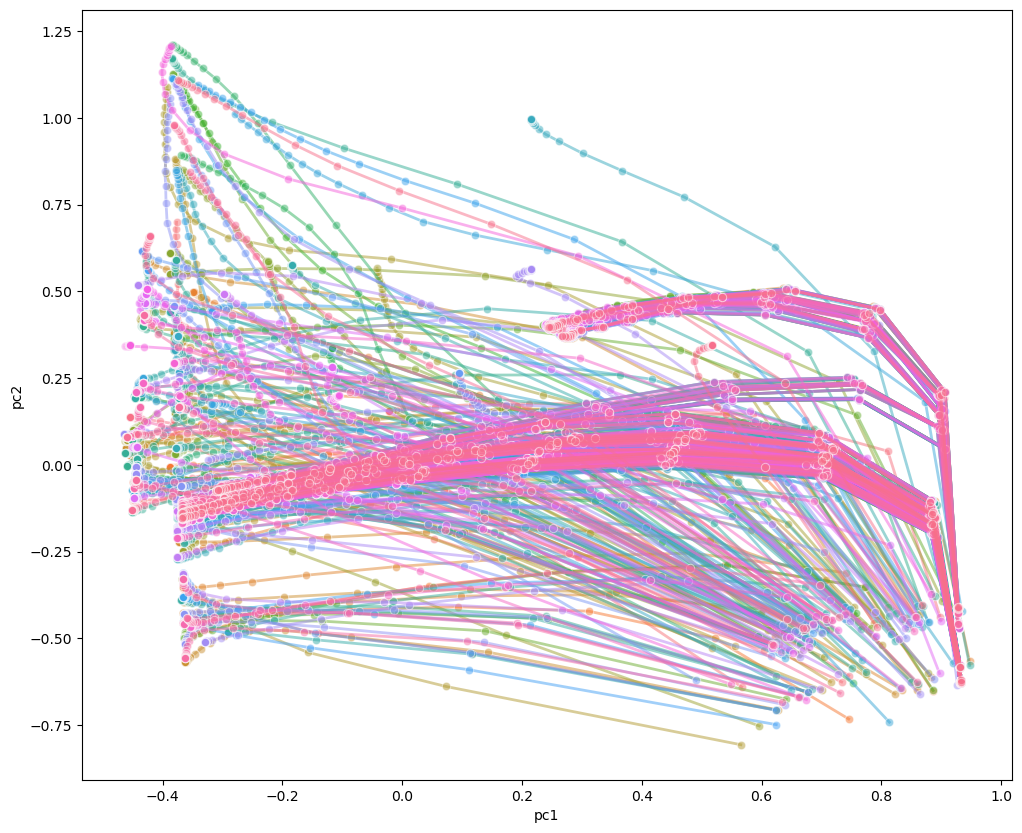

In [36]:
from matplotlib.pyplot import rc_context
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_df,
                        x = 'pc1', y = 'pc2',
                        hue = pca_df['model_id'], sort = False,
                        marker = 'o', linewidth = 2,
                        alpha = .5 
                        #markersize = 10
                        )
    plot.get_legend().remove()

plt.show()

# Trajectory comparison using single variable from PCA

In [38]:
import tslearn
from tslearn.datasets import CachedDatasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.preprocessing import TimeSeriesResampler
import numpy


seed = 0
numpy.random.seed(seed)

Euclidean k-means
0.243 --> 0.182 --> 0.174 --> 0.167 --> 0.164 --> 0.161 --> 0.158 --> 0.151 --> 0.146 --> 0.145 --> 0.143 --> 0.142 --> 0.141 --> 0.141 --> 0.141 --> 


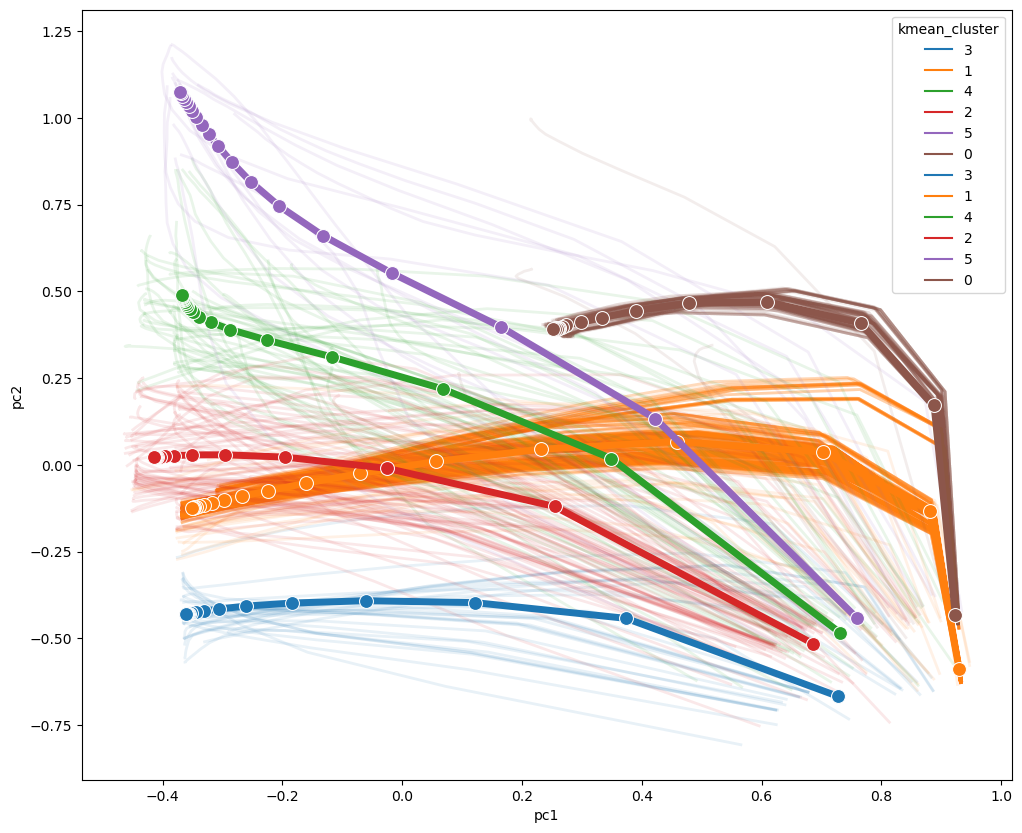

In [41]:
pca_df.model_id = pca_df.model_id.astype('category')
model_name = pca_df.model_id.cat.categories

model_pca_all = {}
for i in model_name:
    model_pca = pca_df.loc[pca_df.model_id == i,['pc1','pc2']].values
    model_pca_all[i] = np.array(model_pca)

pca_all_trajectory = np.array(list(model_pca_all.values()))

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=6, verbose=True, random_state=seed)
y_pred = km.fit_predict(pca_all_trajectory)


# Plot the trajectory
cluster_dict = dict(zip(list(model_name),list(y_pred)))
pca_df['kmean_cluster'] = pca_df['model_id']
pca_df['kmean_cluster'] = pca_df['kmean_cluster'].replace(cluster_dict)

## Calculate the mean position
kmean_cluster = pca_df.groupby(['timepoint','kmean_cluster'])[['pc1','pc2']].mean()

## Plot with Seaborn
import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_df, 
                        x = 'pc1',y='pc2',
                        hue = 'kmean_cluster', units = 'model_id', estimator = None, lw=2, alpha = .1,
                        sort = False)
    plot.get_legend().remove()

    plot2 = sns.lineplot(data = kmean_cluster, 
                        x = 'pc1',y='pc2',
                        hue = 'kmean_cluster',
                        sort = False, marker = 'o', linewidth = 5, markersize = 10)

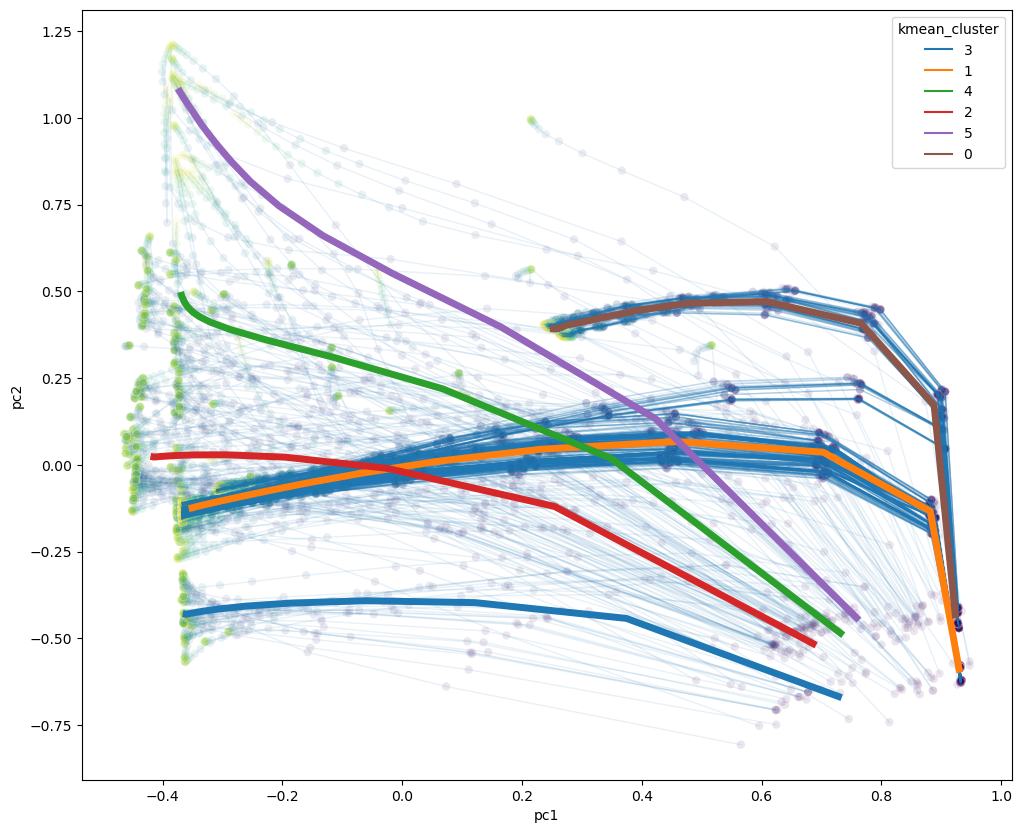

In [42]:
with rc_context({"figure.figsize": (12, 10)}):
    plot1 = sns.scatterplot(data = pca_df, 
                x = 'pc1',y='pc2',
                c = pca_df.timepoint, alpha = .1)
    
    plot2 = sns.lineplot(data = pca_df, 
                x = 'pc1',y='pc2',
                units = 'model_id', estimator = None, lw=1, alpha = .1)
    
    plot3 = sns.lineplot(data = kmean_cluster, 
                            x = 'pc1',y='pc2',
                            hue = 'kmean_cluster',
                            sort = False, linewidth = 5, markersize = 10)
    
plt.show()

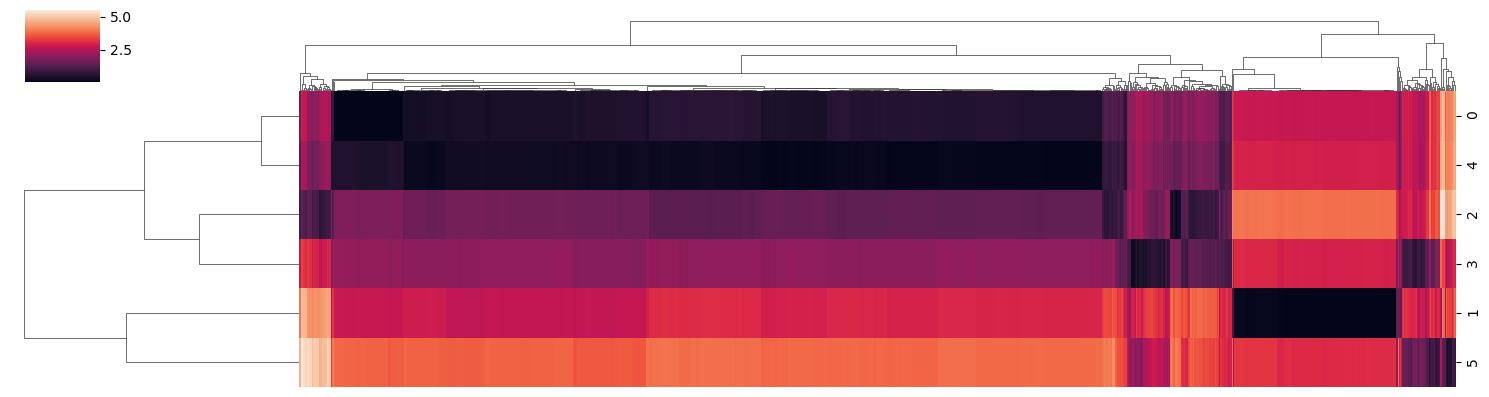

In [11]:
# Obtain the distance space from `tslearn`
distance_space = km.transform(pca_all_trajectory)
distance_space = pd.DataFrame(distance_space)
distance_space.index = list(model_pca_all.keys())

# Plot the distance space to each cluster for each model
sns.clustermap(distance_space.transpose(), figsize = (15,4), xticklabels=False)
plt.show()

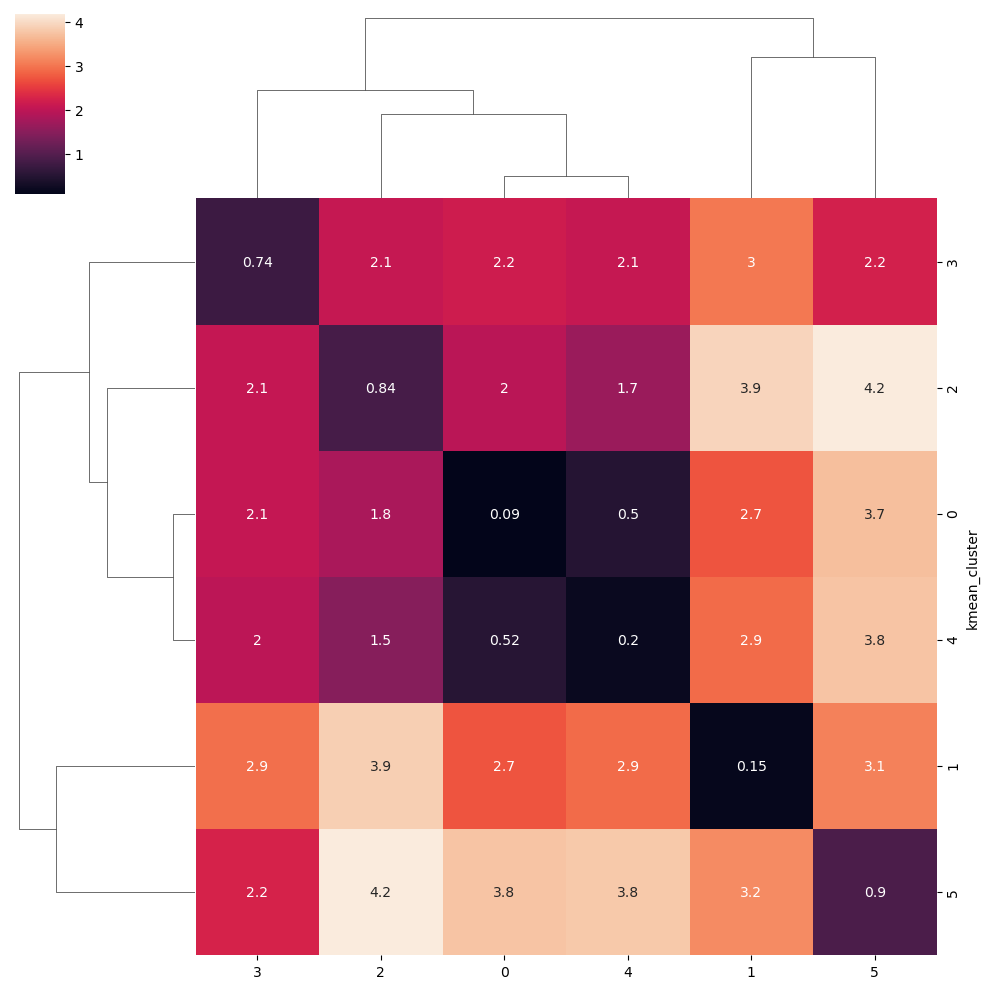

In [12]:
# Attach cluster information
distance_space['kmean_cluster'] = list(distance_space.index)
distance_space['kmean_cluster'] = distance_space['kmean_cluster'].replace(cluster_dict)
distance_space_group = distance_space.groupby(['kmean_cluster']).mean()

# Plot the distance space by group
sns.clustermap(distance_space_group, figsize = (10,10), annot = True)
plt.show()

/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, me

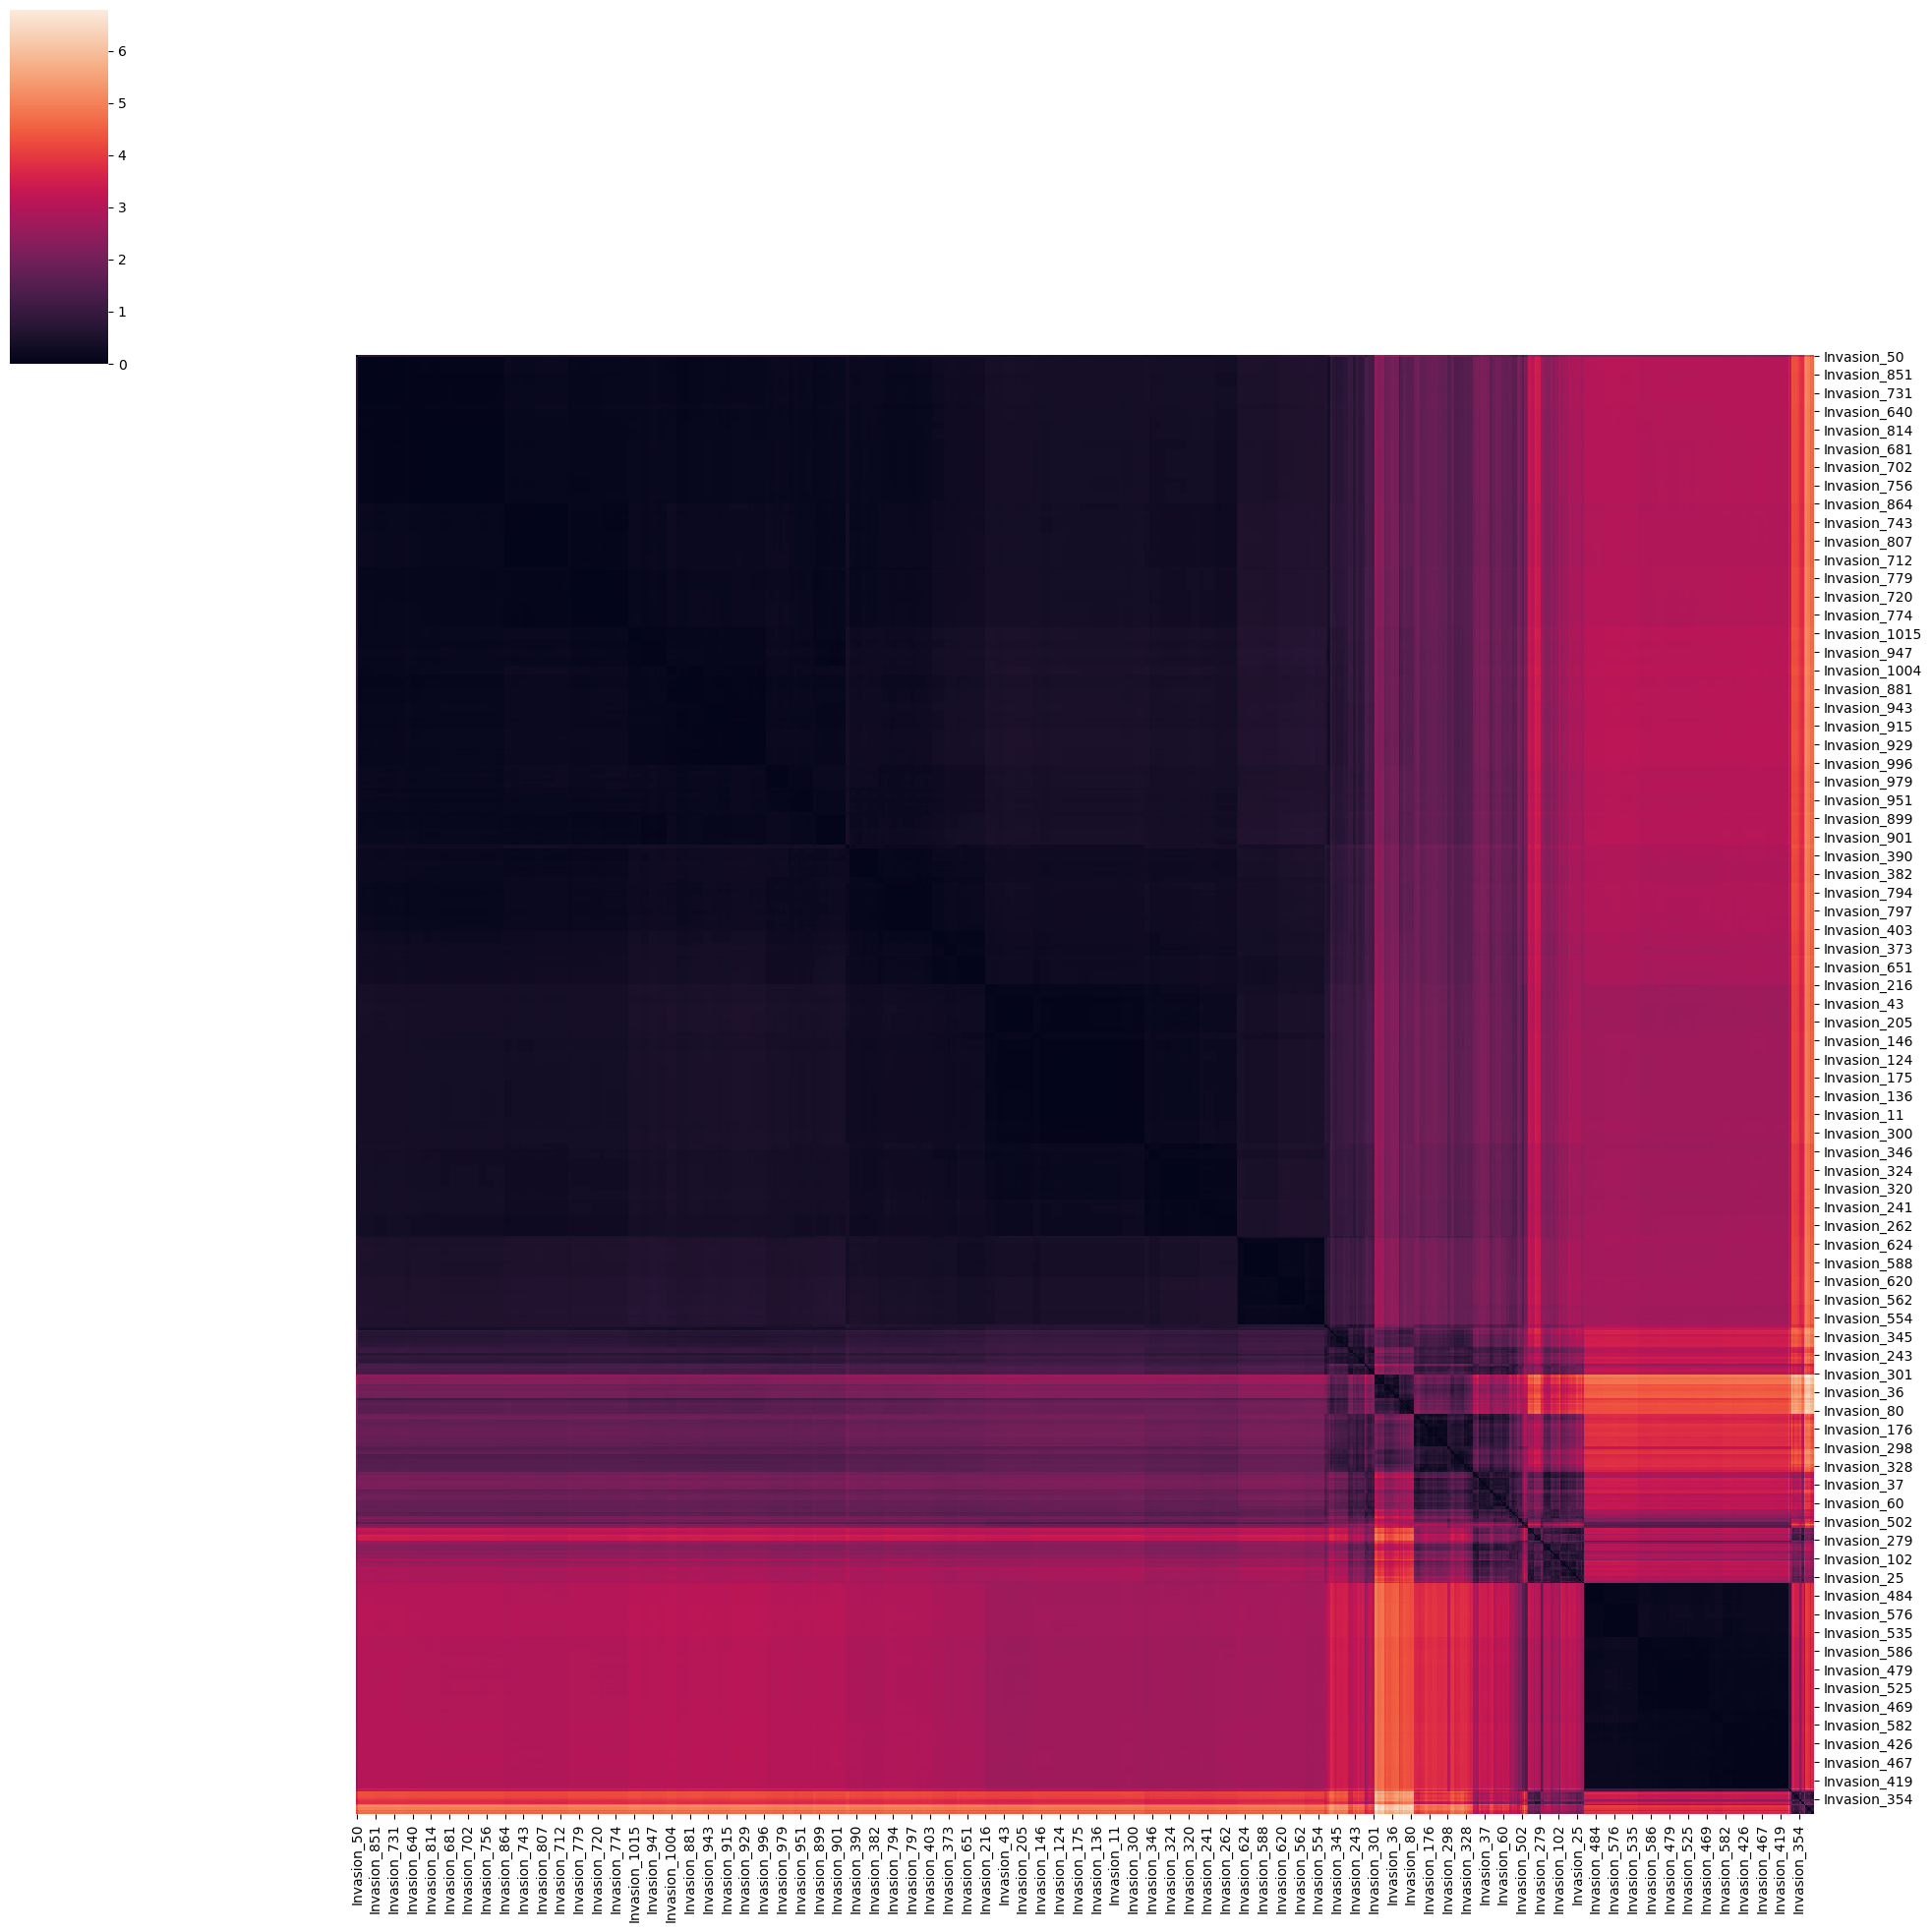

In [35]:
# Get model_id
model_id = list(cluster_dict.keys())

# Compact data into the right format
kmean_cluster = pca_mat.groupby(['model_id','timepoint'])[['pca1','pca2']].mean()

# Calculate Euclidean distances between clusters
distance_matrix = pd.DataFrame()
for i in model_id:
    time_series1 = numpy.array(kmean_cluster.loc[i])
    distance_cluster = []
    for j in model_id:
        time_series2 = numpy.array(kmean_cluster.loc[j])
        distance = numpy.sqrt(numpy.sum((time_series1 - time_series2)**2))
        distance_cluster.append(distance)
    distance_matrix = pd.concat([distance_matrix,pd.DataFrame(distance_cluster)],axis = 1)
distance_matrix.columns = model_id
distance_matrix.index = model_id

# Plot Euclidean distance using clustermap
g = sns.clustermap(distance_matrix, figsize = (20,20))

# Hiding the row dendrogram
g.ax_row_dendrogram.set_visible(False)

# Hiding the column dendrogram
g.ax_col_dendrogram.set_visible(False)

plt.show()

/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


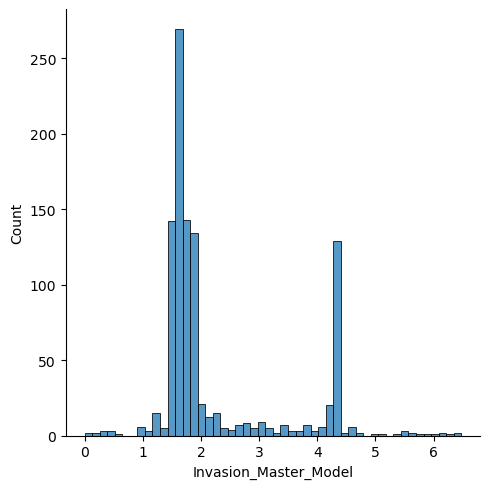

In [43]:
sns.displot(distance_matrix.Invasion_Master_Model.sort_values(), kind = 'hist')
plt.show()

In [23]:
test = pd.DataFrame(pd.Series(cluster_dict))
test.columns = ['cluster']
test.to_csv('/home/spankaew/Git/BooleanBenchmark/tmp/Invasion_model_clusters.csv')

# Focus on logical function
In this part of the examples, we look at the logical function underlying each model and ask whether there is an association between logical equations and the model

In [16]:
# Get the list of files in the model folder
model_folder = '/home/spankaew/Git/BooleanBenchmark/models/Invasion/'
model_files = os.listdir(model_folder)

model_logic = pd.DataFrame()

for i in model_files:
    logic = pd.read_csv(model_folder + i, index_col=0, header = None)
    logic.columns = [i.split('.')[0]]
    model_logic = pd.concat([model_logic, logic], axis = 1, ignore_index=False)
model_logic.index.name = None
model_logic = model_logic.transpose()

In [31]:
# Select master model
master_model = model_logic.loc['Invasion_Master_Model']

# find matches
model_logic_test = model_logic.drop('Invasion_Master_Model', axis = 0)
matches = model_logic_test.apply(lambda row: row.equals(master_model), axis = 1)

# Check if any match is found
matches.any()

False

In [45]:
model_logic.loc[['Invasion_Master_Model','Invasion_0']]

,AKT1,AKT2,Apoptosis,CDH1,CDH2,CTNNB1,CellCycleArrest,DKK1,DNAdamage,ECMicroenv,EMT,ERK,GF,Invasion,Metastasis,Migration,NICD,SMAD,SNAI1,SNAI2,TGFbeta,TWIST1,VIM,ZEB1,ZEB2,miR200,miR203,miR34,p21,p53,p63,p73
Invasion_Master_Model,(!CDH1&CDH2&CTNNB1&!miR34&!p53)|(!CDH1&CTNNB1...,(CDH2&TWIST1&!miR203&!miR34&!p53)|(GF&TWIST1&...,(!AKT1&!ERK&!ZEB2&miR200)|(!AKT1&!ERK&!ZEB2&m...,!AKT2&!SNAI1&!SNAI2&!TWIST1&!ZEB1&!ZEB2,TWIST1,!AKT1&!CDH1&!CDH2&!DKK1&!miR200&!miR34&!p53&!p63,(!AKT1&ZEB2)|(!AKT1&miR200)|(!AKT1&miR203)|(!...,CTNNB1|NICD,DNAdamage,ECMicroenv,!CDH1&CDH2,(!AKT1&CDH2)|(!AKT1&GF)|(!AKT1&NICD)|(!AKT1&S...,(!CDH1&CDH2)|(!CDH1&GF),CTNNB1|(CDH2&SMAD),Migration,!AKT1&AKT2&EMT&ERK&Invasion&VIM&!miR200&!p63,ECMicroenv&!miR200&!miR34&!p53&!p63&!p73,TGFbeta&!miR200&!miR203,(!CTNNB1&NICD&!miR203&!miR34&!p53)|(!CTNNB1&T...,(CTNNB1&!miR200&!miR203&!p53)|(NICD&!miR200&!...,(!CTNNB1&ECMicroenv)|(!CTNNB1&NICD),CTNNB1|NICD|SNAI1,CTNNB1|ZEB2,(CTNNB1&!miR200)|(NICD&!miR200)|(SNAI1&TWIST1...,(NICD&!miR200&!miR203)|(SNAI1&!miR200&!miR203...,(!AKT2&!SNAI1&!SNAI2&!ZEB1&!ZEB2&p53)|(!AKT2&...,!SNAI1&!ZEB1&!ZEB2&p53,(!AKT1&AKT2&!SNAI1&!ZEB1&!ZEB2&p53&!p63)|(!AK...,(!AKT1&AKT2&!ERK)|(!AKT1&!ERK&NICD&SMAD)|(!AK...,(!AKT1&!AKT2&CTNNB1&!SNAI2&!p73)|(!AKT1&!AKT2...,!AKT1&!AKT2&DNAdamage&!NICD&!miR203&!p53,!AKT1&!AKT2&DNAdamage&!ZEB1&!p53
Invasion_0,(!GF&!TGFbeta&!CDH1&!CDH2&CTNNB1&NICD&!p53&!m...,(!GF&!TGFbeta&!CDH2&TWIST1&NICD&!p53&!miR203&...,(!ZEB2&!AKT1&!p63&!p53&!p73&!miR200&miR34&!ER...,!TWIST1&!SNAI1&!SNAI2&!ZEB1&!ZEB2&!AKT2,TWIST1,!CDH1&!CDH2&!AKT1&!DKK1&!p63&!p53&!miR200&!miR34,(!p21&!ZEB2&!AKT1&!miR200&!miR203&miR34)|(!p2...,(!CTNNB1&NICD)|CTNNB1,DNAdamage,ECMicroenv,!CDH1&CDH2,(!GF&!CDH2&!AKT1&!NICD&SMAD)|(!GF&!CDH2&!AKT1...,(!GF&!CDH1&CDH2)|(GF&!CDH1),(!CDH2&CTNNB1)|(CDH2&!CTNNB1&SMAD)|(CDH2&CTNNB1),Migration,Invasion&EMT&VIM&!AKT1&!p63&!miR200&AKT2&ERK,ECMicroenv&!p63&!p53&!p73&!miR200&!miR34,TGFbeta&!miR200&!miR203,(!TWIST1&!CTNNB1&NICD&!p53&!miR203&!miR34)|(T...,(!TWIST1&!CTNNB1&NICD&!p53&!miR200&!miR203)|(...,(!ECMicroenv&!CTNNB1&NICD)|(ECMicroenv&!CTNNB1),(!SNAI1&!CTNNB1&NICD)|(!SNAI1&CTNNB1)|SNAI1,(!ZEB2&CTNNB1)|ZEB2,(!TWIST1&!SNAI2&!CTNNB1&NICD&!miR200)|(!TWIST...,(!TWIST1&!SNAI1&NICD&!miR200&!miR203)|(!TWIST...,(!SNAI1&!SNAI2&!ZEB1&!ZEB2&!p63&!p53&p73&!AKT...,!SNAI1&!ZEB1&!ZEB2&p53,(!SNAI1&!ZEB1&!ZEB2&!AKT1&!p63&!p53&p73&AKT2)...,(!AKT1&!NICD&!p63&!p53&!p73&AKT2&!ERK)|(!AKT1...,(!DNAdamage&!SNAI2&!AKT1&!CTNNB1&!NICD&!p73&m...,DNAdamage&!AKT1&!NICD&!p53&!miR203&!AKT2,DNAdamage&!ZEB1&!AKT1&!p53&!AKT2


In [16]:
cpal = ['#d73027', '#f46d43', '#fdae61', '#fee08b', '#ffffbf', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850', '#006837']

/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


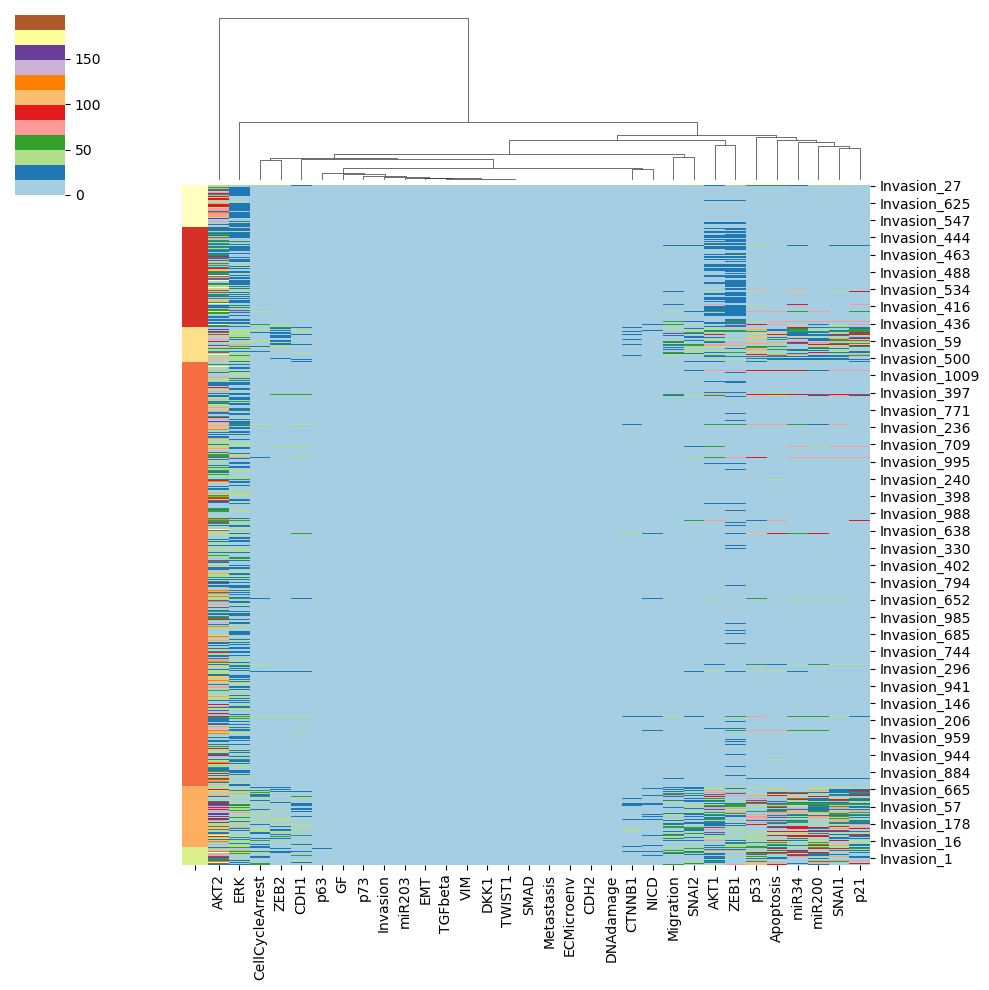

In [17]:
model_logic_categorical = model_logic.copy()
for i in model_logic_categorical.columns:
    model_logic_categorical[i], _ = pd.factorize(model_logic[i])

# Create cluster color palette
kmean_index = pd.Series(model_logic.index, index = model_logic.index)
kmean_index = kmean_index.replace(cluster_dict)
lut = dict(zip(kmean_index.unique(), cpal))
row_colors = kmean_index.map(lut)

sort_index = list(kmean_index.sort_values().index)

# Plot clustermap
sns.clustermap(model_logic_categorical.loc[sort_index],
            row_colors = row_colors[sort_index], 
            row_cluster=False,
            col_cluster = True,
            cmap = 'Paired')

In [13]:
var_logic_length = []
for i in model_logic.columns:
    num_logic = model_logic[i].value_counts().size
    var_logic_length.append(num_logic)
var_logic_length = pd.DataFrame(var_logic_length, columns = ['logic_length'], index = model_logic.columns)

with rc_context({"figure.figsize": (12, 10)}):
    ax = sns.barplot(x = var_logic_length.index, 
                y = var_logic_length.logic_length)
    ax.bar_label(ax.containers[0], fontsize=10);
    plt.xticks(rotation = 90)
plt.show()

IndentationError: unexpected indent (4160992594.py, line 8)

In [45]:
model_logic['kmean_cluster'] = list(model_logic.index)
model_logic['kmean_cluster'] = model_logic['kmean_cluster'].replace(cluster_dict)


var_logic_clust = pd.DataFrame()
for i in list(range(6)):
    model_logic_sub = model_logic.loc[model_logic.kmean_cluster == i]
    model_logic_sub = model_logic_sub.drop(['kmean_cluster'], axis = 1)
    var_logic_length = []
    for j in model_logic_sub.columns:
        num_logic = model_logic_sub[j].value_counts().size
        var_logic_length.append(num_logic)
    var_logic_length = pd.DataFrame(var_logic_length, columns = ['logic_length'], index = model_logic_sub.columns)
    var_logic_clust = pd.concat([var_logic_clust, var_logic_length], axis = 1, ignore_index = False)
var_logic_clust.columns = list(range(6))

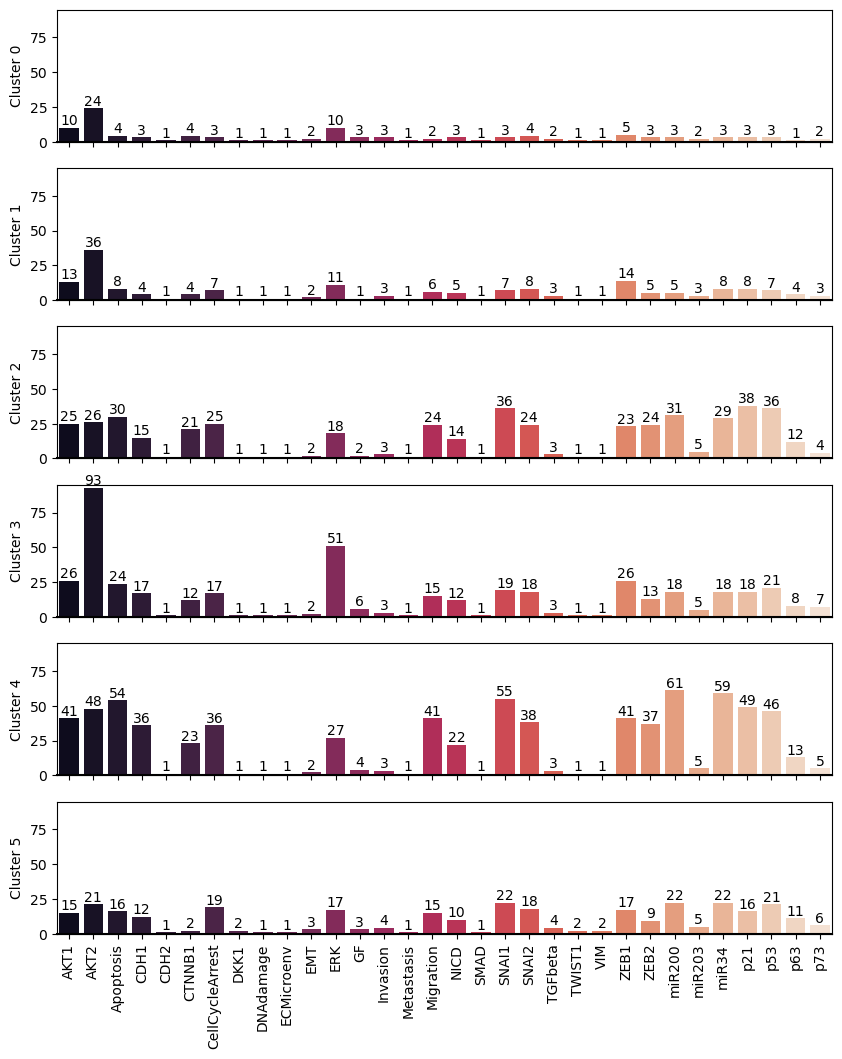

In [55]:
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(10, 12), sharex=True)
plt.ylim(0,65)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[0], palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Cluster 0")
ax1.bar_label(ax1.containers[0], fontsize=10)
ax1.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[1], palette="rocket", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Cluster 1")
ax2.bar_label(ax2.containers[0], fontsize=10)
ax2.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[2], palette="rocket", ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("Cluster 2")
ax3.bar_label(ax3.containers[0], fontsize=10)
ax3.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[3], palette="rocket", ax=ax4)
ax4.axhline(0, color="k", clip_on=False)
ax4.set_ylabel("Cluster 3")
ax4.bar_label(ax4.containers[0], fontsize=10)
ax4.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[4], palette="rocket", ax=ax5)
ax5.axhline(0, color="k", clip_on=False)
ax5.set_ylabel("Cluster 4")
ax5.bar_label(ax5.containers[0], fontsize=10)
ax5.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[5], palette="rocket", ax=ax6)
ax6.axhline(0, color="k", clip_on=False)
ax6.set_ylabel("Cluster 5")
ax6.bar_label(ax6.containers[0], fontsize=10)
ax6.set_ylim(0,95)

plt.xticks(rotation = 90)
plt.show()